In [25]:
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import glob
import keras
import random
import pandas as pd
import tensorflow as tf
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelBinarizer

In [26]:
# check for GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7641225290452431214
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6392119296
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9692463422992060212
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [27]:
# get the cats and dogs
catDir = os.getcwd() + '/train/cat/'
dogDir = os.getcwd() + '/train/dog/'
print(catDir)

C:\Users\jiroj\Documents\Northeastern\CS7180\project/train/cat/


In [28]:
# downloading files
catFiles = [(file, 0) for file in glob.glob(catDir + '*')]
dogFiles = [(file, 1) for file in glob.glob(dogDir + '*')]

In [29]:
# randomize files
allFiles = catFiles + dogFiles
random.Random(42).shuffle(allFiles)

In [30]:
# Create a DataFrame
df = pd.DataFrame(allFiles, columns=['FilePath', 'True_Label'])

x = df['FilePath'].values
y = df['True_Label'].values
xTrain, xTest, yTrain, yTest = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

train_df = pd.DataFrame({'FilePath': xTrain, 'True_Label': yTrain})
test_df = pd.DataFrame({'FilePath': xTest, 'True_Label': yTest})

In [31]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
CHANNELS = 3

# load up an image and process it
def loadAndProcessIMG(imgPath):
    image = cv2.imread(imgPath)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = np.array(image, dtype="float32") / 255.0
    return image

xTrainProcess = np.array([loadAndProcessIMG(f) for f in xTrain])
xTestProcess = np.array([loadAndProcessIMG(f) for f in xTest])

lb = LabelBinarizer()
yTrainProcess = lb.fit_transform(yTrain)
yTestProcess = lb.transform(yTest)

# augment data
trainDataGen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [47]:
# primary cnn to be using
cnnModel = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

cnnModel.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

cnnHistory = cnnModel.fit(
    trainDataGen.flow(xTrainProcess, yTrainProcess, batch_size=32),
    validation_data=(xTestProcess, yTestProcess),
    epochs=75,
    verbose=1)

Epoch 1/75
75/75 [==============================] - 60s 785ms/step - loss: 0.6920 - accuracy: 0.5238 - val_loss: 0.6800 - val_accuracy: 0.5050
Epoch 2/75
75/75 [==============================] - 18s 245ms/step - loss: 0.6716 - accuracy: 0.5742 - val_loss: 0.6783 - val_accuracy: 0.5267
Epoch 3/75
75/75 [==============================] - 19s 249ms/step - loss: 0.6421 - accuracy: 0.6187 - val_loss: 0.5978 - val_accuracy: 0.6700
Epoch 4/75
75/75 [==============================] - 19s 250ms/step - loss: 0.6177 - accuracy: 0.6642 - val_loss: 0.5422 - val_accuracy: 0.7450
Epoch 5/75
75/75 [==============================] - 19s 247ms/step - loss: 0.5922 - accuracy: 0.6767 - val_loss: 0.5238 - val_accuracy: 0.7450
Epoch 6/75
75/75 [==============================] - 18s 245ms/step - loss: 0.5913 - accuracy: 0.6888 - val_loss: 0.5069 - val_accuracy: 0.7833
Epoch 7/75
75/75 [==============================] - 19s 246ms/step - loss: 0.5576 - accuracy: 0.7133 - val_loss: 0.5032 - val_accuracy: 0.7717

Epoch 58/75
75/75 [==============================] - 20s 263ms/step - loss: 0.2455 - accuracy: 0.8958 - val_loss: 0.3585 - val_accuracy: 0.8567
Epoch 59/75
75/75 [==============================] - 20s 266ms/step - loss: 0.2617 - accuracy: 0.8900 - val_loss: 0.3311 - val_accuracy: 0.8500
Epoch 60/75
75/75 [==============================] - 20s 265ms/step - loss: 0.2571 - accuracy: 0.8942 - val_loss: 0.3200 - val_accuracy: 0.8517
Epoch 61/75
75/75 [==============================] - 21s 275ms/step - loss: 0.2563 - accuracy: 0.8954 - val_loss: 0.3726 - val_accuracy: 0.8383
Epoch 62/75
75/75 [==============================] - 21s 275ms/step - loss: 0.2533 - accuracy: 0.8867 - val_loss: 0.3265 - val_accuracy: 0.8550
Epoch 63/75
75/75 [==============================] - 22s 286ms/step - loss: 0.2417 - accuracy: 0.8942 - val_loss: 0.3705 - val_accuracy: 0.8567
Epoch 64/75
75/75 [==============================] - 20s 263ms/step - loss: 0.2387 - accuracy: 0.8988 - val_loss: 0.3475 - val_accuracy:

In [48]:
cnnModel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 26, 26, 128)     

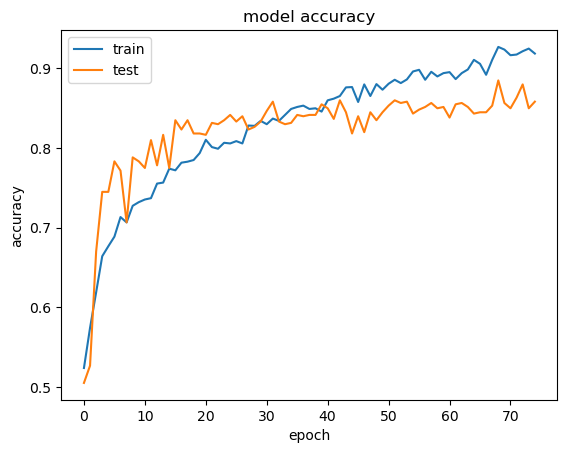

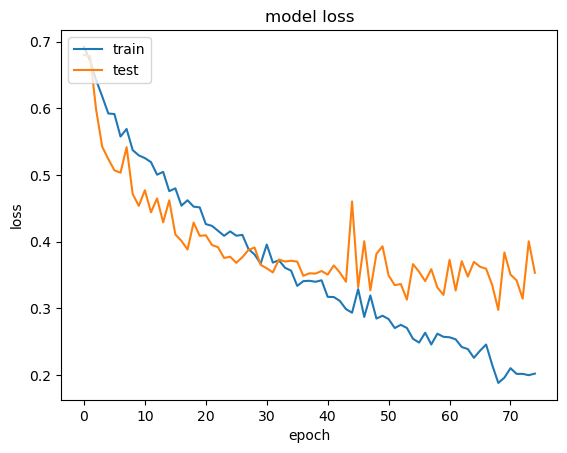

In [49]:
plt.plot(cnnHistory.history['accuracy'])
plt.plot(cnnHistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnnHistory.history['loss'])
plt.plot(cnnHistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
# preprocess images to be fed into the model
def cnnPreprocessImg(pathIMG):
    img = image.load_img(pathIMG, target_size=(IMG_WIDTH, IMG_HEIGHT))
    imgArray = image.img_to_array(img)
    imgArray = np.expand_dims(imgArray, axis=0)
    imgArray /= 255.  # Scale image pixels to 0-1
    return imgArray

def cnnPredict(model, imgArray):
    return model.predict(imgArray)

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


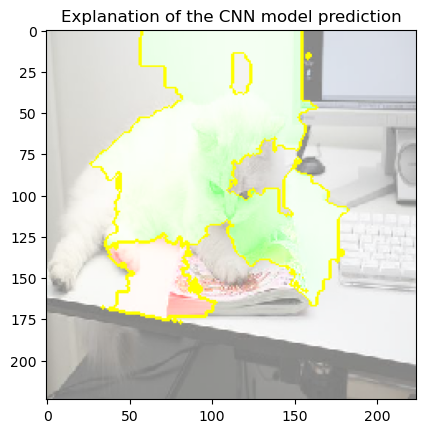

Predicted class: Cat


In [44]:
# use LIME 
explainer = lime_image.LimeImageExplainer()
imgPath = catDir + 'cat.666.jpg'
# imgPath = dogDir + 'dog.333.jpg'

preprocessedIMG = cnnPreprocessImg(imgPath)
pred = cnnPredict(cnnModel, preprocessedIMG)

explanation = explainer.explain_instance(
    image=preprocessedIMG[0],
    classifier_fn=lambda x: cnnPredict(cnnModel, x),
    top_labels=2,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    num_features=5,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title('Explanation of the CNN model prediction')
plt.show()
print(f"Predicted class: {'Dog' if pred[0][0] > 0.5 else 'Cat'}")

In [33]:
#####################################################################
# FROM Team, K. (n.d.). Keras documentation: Grad-CAM class activation 
# visualization. https://keras.io/examples/vision/grad_cam/  
#####################################################################

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Display Grad CAM
    plt.matshow(superimposed_img)
    plt.show()

In [ ]:
# testing for GRAD-CAM
imgPath = catDir + 'cat.1499.jpg'
# img_path = normal_dir + '00202.png'
preprocessIMG = cnnPreprocessImg(imgPath)
print(len(preprocessIMG))
plt.imshow(preprocessIMG[0])
plt.show()
# Print what the top predicted class is
preds = cnnModel.predict(preprocessIMG)
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(preprocessIMG, cnnModel, 'conv2d_19')

print(preds[0][0])
print(f"Predicted class: {'Dog' if preds[0][0] > 0.5 else 'Cat'}")
print(f"{preds[0][0]*100 if preds[0][0] > 0.5 else (1-preds[0][0])*100}" + "% confidence")
# Display heatmap
save_and_display_gradcam(imgPath, heatmap)

1


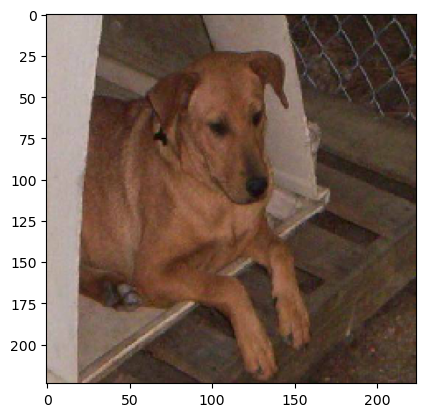

1/1 [==============================] - 0s 22ms/step
0.43355772
Predicted class: Cat
56.64422810077667% confidence


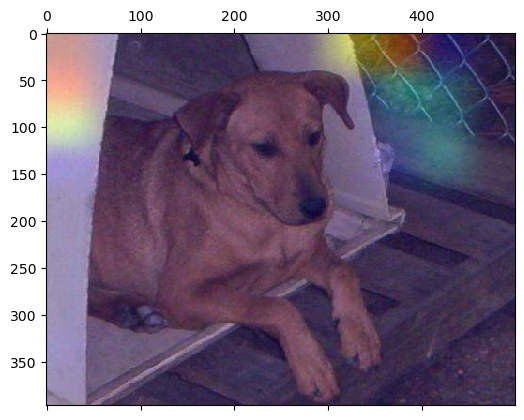

In [37]:
# testing for GRAD-CAM
imgPath = dogDir + 'dog.100.jpg'
# img_path = normal_dir + '00202.png'
preprocessIMG = cnnPreprocessImg(imgPath)
print(len(preprocessIMG))
plt.imshow(preprocessIMG[0])
plt.show()
# Print what the top predicted class is
preds = cnnModel.predict(preprocessIMG)
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(preprocessIMG, cnnModel, 'conv2d_19')

print(preds[0][0])
print(f"Predicted class: {'Dog' if preds[0][0] > 0.5 else 'Cat'}")
print(f"{preds[0][0]*100 if preds[0][0] > 0.5 else (1-preds[0][0])*100}" + "% confidence")
# Display heatmap
save_and_display_gradcam(imgPath, heatmap)

In [63]:
# save the current model
cnnModel.save('./app/catdog.keras')

In [34]:
cnnModel = keras.models.load_model('app/catdog.keras')


In [66]:
tf.keras.models.save_model(cnnModel, './app/catdog.keras')

In [67]:
newModel = tf.keras.models.load_model('./app/catdog.keras')

1


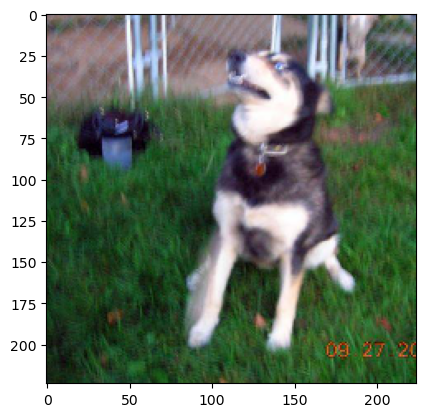

1/1 [==============================] - 0s 173ms/step
0.98731405
Predicted class: Dog
98.73140454292297% confidence


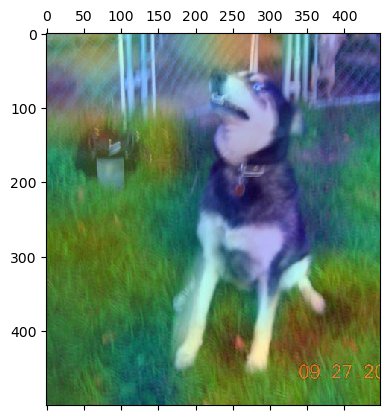

In [68]:
# loaded new model testing
imgPath = dogDir + 'dog.120.jpg'
# img_path = normal_dir + '00202.png'
preprocessIMG = cnnPreprocessImg(imgPath)
print(len(preprocessIMG))
plt.imshow(preprocessIMG[0])
plt.show()
# Print what the top predicted class is
preds = newModel.predict(preprocessIMG)
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(preprocessIMG, newModel, 'conv2d_19')

print(preds[0][0])
print(f"Predicted class: {'Dog' if preds[0][0] > 0.5 else 'Cat'}")
print(f"{preds[0][0]*100 if preds[0][0] > 0.5 else (1-preds[0][0])*100}" + "% confidence")
# Display heatmap
save_and_display_gradcam(imgPath, heatmap)